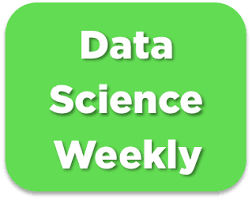

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
pip install plotly==4.9.0

  Using cached plotly-4.9.0-py2.py3-none-any.whl (12.9 MB)
Processing /home/jovyan/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56/retrying-1.3.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install jupyterlab "ipywidgets>=7.5"

Note: you may need to restart the kernel to use updated packages.


In [3]:
!jupyter labextension install jupyterlab-plotly@4.9.0

Building jupyterlab assets (build:prod:minimize)


In [4]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.9.0

Building jupyterlab assets (build:prod:minimize)


In [5]:
!jupyter labextension list

JupyterLab v2.2.8
Known labextensions:
   app dir: /opt/conda/share/jupyter/lab
        @bokeh/jupyter_bokeh v2.0.3  enabled  OK
        @jupyter-widgets/jupyterlab-manager v2.0.0  enabled  OK
        jupyter-matplotlib v0.7.4  enabled  OK
        jupyterlab-plotly v4.9.0  enabled  OK
        plotlywidget v4.9.0  enabled  OK


In [6]:
!jupyter lab build

[LabBuildApp] JupyterLab 2.2.8
[LabBuildApp] Building in /opt/conda/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)


In [389]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
!pip install xgboost
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import AdaBoostRegressor , AdaBoostClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as defaul
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [690]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [344]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [345]:
# The dataset is quite big : you must create a sample of the dataset before making any visualizations !
data_sample = data.sample(10000)

In [346]:
data_sample

,country,age,new_user,source,total_pages_visited,converted
272312,UK,33,1,Ads,5,0
207920,US,21,0,Seo,2,0
243158,US,20,1,Seo,10,0
41047,US,29,0,Seo,10,0
71691,US,33,1,Seo,8,0
...,...,...,...,...,...,...
8299,UK,36,1,Ads,3,0
202301,China,40,1,Ads,9,0
261195,US,32,1,Seo,6,0
211527,US,35,1,Direct,6,0


In [347]:
data_sample.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.00000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5616,NaN,NaN,4923,NaN,NaN
mean,NaN,30.584000,0.687500,NaN,4.95150,0.036300
std,NaN,8.268312,0.463536,NaN,3.37655,0.187045
min,NaN,17.000000,0.000000,NaN,1.00000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.00000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.00000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.00000,0.000000


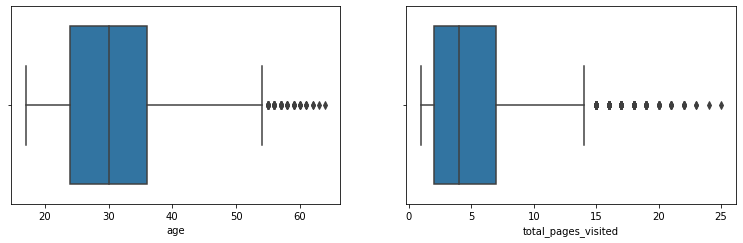

In [348]:
plt.figure(figsize=(13,8))
plt.subplot(221)
sns.boxplot(data=data_sample, x='age')
plt.subplot(222)
sns.boxplot(data=data_sample, x='total_pages_visited')
plt.show()

In [349]:
data_sample['converted'].value_counts().values

array([9637,  363])

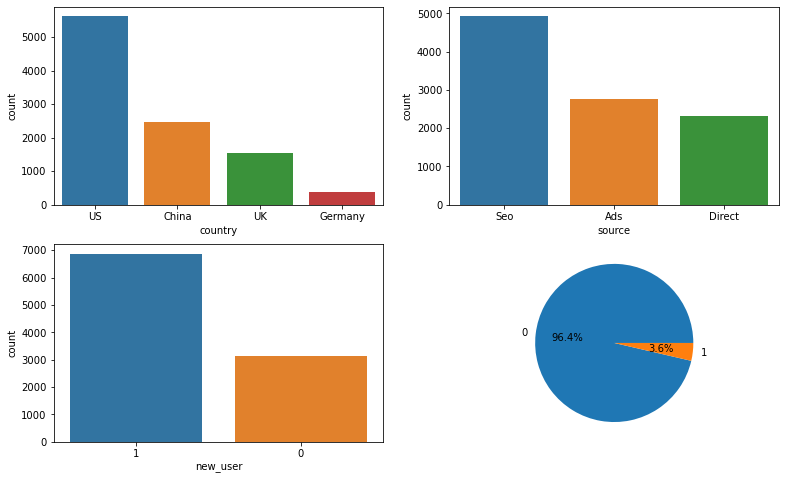

In [350]:
plt.figure(figsize=(13,8))
plt.subplot(221)
sns.countplot(data=data_sample, x='country', order=data_sample['country'].value_counts().index)
plt.subplot(222)
sns.countplot(data=data_sample, x='source', order=data_sample['source'].value_counts().index)
plt.subplot(223)
sns.countplot(data=data_sample, x='new_user', order=data_sample['new_user'].value_counts().index)
plt.subplot(224)
plt.pie(data_sample['converted'].value_counts().values, labels=data_sample['converted'].value_counts().index, autopct='%1.1f%%')
plt.show()


<AxesSubplot:xlabel='country', ylabel='count'>

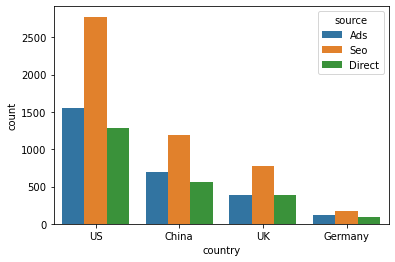

In [351]:
sns.countplot(data=data_sample, x='country', hue='source', order=data_sample['country'].value_counts().index)

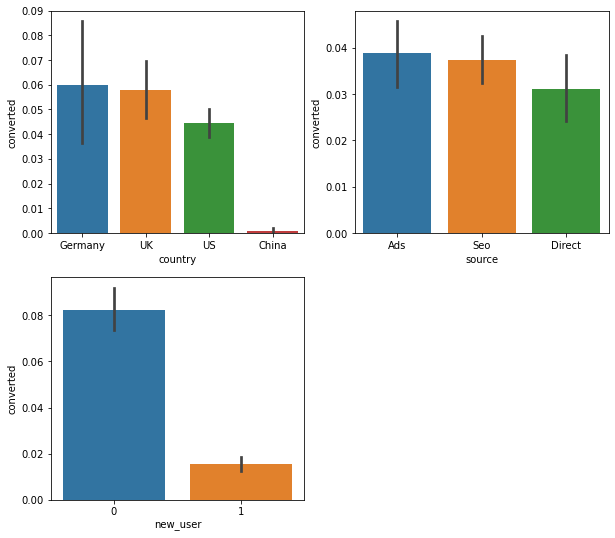

In [352]:
plt.figure(figsize=(10,9))
plt.subplot(221)
sns.barplot(data=data_sample, x='country', y='converted', order=data_sample.groupby('country')['converted'].mean().sort_values(ascending=False).index.values)
plt.subplot(222)
sns.barplot(data=data_sample, x='source', y='converted', order=data_sample.groupby('source')['converted'].mean().sort_values(ascending=False).index.values)
plt.subplot(223)
sns.barplot(data=data_sample, x='new_user', y='converted', order=data_sample.groupby('new_user')['converted'].mean().sort_values(ascending=False).index.values)
plt.show()

In [353]:
fig=px.bar(data_sample, x='total_pages_visited', y='converted')
fig.show()

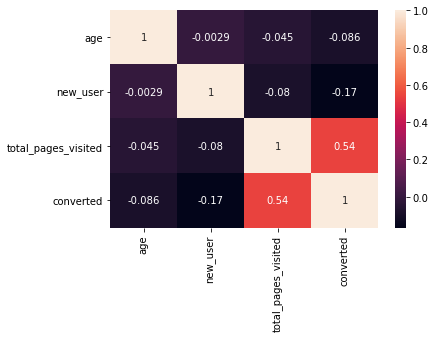

In [354]:
corr=data_sample.corr()
sns.heatmap(corr, annot=True)
plt.show()

# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [355]:
data.isna().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [356]:
data['new_user']= data['new_user'].astype(str)

In [357]:
data.dtypes

country                object
age                     int64
new_user               object
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [251]:
data=data[['country', 'new_user', 'source', 'age', 'total_pages_visited', 'converted']]

In [252]:
liste=['age']
for i in liste:
    to_keep=(data[i] > data[i].mean() - 3*data[i].std()) & (data[i] < data[i].mean() + 3*data[i].std())
    data=data.loc[to_keep,:]

In [358]:
(data['converted']==1).sum()

9180

In [254]:
Y=data['converted']
X=data.drop(['converted'], axis=1)

In [359]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'total_pages_visited']  at positions  [3, 4]
Found categorical features  ['country', 'new_user', 'source']  at positions  [0, 1, 2]


# Regression logistic

In [256]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [257]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[['US' '1' 'Ads' 18 9]
 ['US' '1' 'Ads' 28 2]
 ['US' '1' 'Direct' 25 5]
 ['US' '1' 'Seo' 24 2]
 ['US' '1' 'Ads' 32 3]]
[['China' '0' 'Ads' 32 7]
 ['UK' '1' 'Seo' 30 4]]

[0 0 0 0 0]
[0 0]


## Training pipeline

In [772]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop='first')

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)

In [259]:
# Train model
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [260]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 1 0 0]



## Test pipeline

In [261]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

X_test = featureencoder.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 1.          0.          0.          0.          1.          0.
   1.          0.          0.          0.19049678  0.63421315]
 [ 0.          0.          1.          0.          0.          1.
   0.          0.          1.         -0.05612509 -0.26252922]
 [ 0.          0.          1.          0.          1.          0.
   1.          0.          0.         -0.42605791 -1.15927159]
 [ 0.          0.          0.          1.          0.          1.
   0.          1.          0.          0.06718584 -0.56144334]
 [ 0.          0.          0.          1.          0.          1.
   1.          0.          0.          1.67022803 -0.56144334]]


In [262]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 1 0]



## Performance assessment

In [263]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

f1-score on train set :  0.7651754782346739
f1-score on test set :  0.7572519083969466


In [264]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[218652    860]
 [  2258   5080]]

Confusion matrix on test set : 
[[54678   200]
 [  595  1240]]



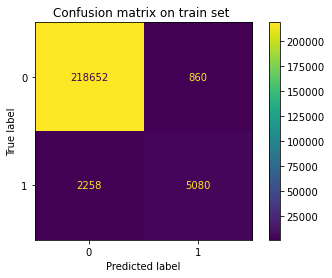

accuracy-score on train set :  0.9862552347366101


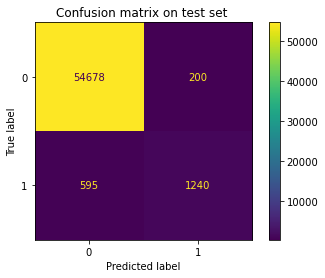

accuracy-score on test set :  0.9859820499709061


In [265]:
# Plot confusion matrix
cm = plot_confusion_matrix(classifier, X_train, Y_train)
cm.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("accuracy-score on train set : ", classifier.score(X_train, Y_train))


cm = plot_confusion_matrix(classifier, X_test, Y_test)
cm.ax_.set_title("Confusion matrix on test set ")
plt.show() # Show graph
print("accuracy-score on test set : ", classifier.score(X_test, Y_test))


In [266]:
recall_score(Y_test, Y_test_pred)

0.6757493188010899

In [267]:
precision_score(Y_test, Y_test_pred)

0.8611111111111112

In [268]:
classifier.coef_[0]

array([-2.69455204,  1.16408768,  0.95218623,  0.5784392 ,  0.87262486,
       -0.87246379,  0.09998348, -0.14397569,  0.04415328, -0.6000099 ,
        2.53405438])

In [269]:
categorical_column_names = featureencoder.transformers_[0][1].categories_
categorical_column_names

[array(['China', 'Germany', 'UK', 'US'], dtype=object),
 array(['0', '1'], dtype=object),
 array(['Ads', 'Direct', 'Seo'], dtype=object)]

In [270]:
numerical_column_names = X.loc[:, numeric_features].columns
numerical_column_names

Index(['age', 'total_pages_visited'], dtype='object')

In [271]:
all_column_names = np.append(categorical_column_names, numerical_column_names)
all_column_names=np.concatenate(all_column_names, axis=None)
all_column_names

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



array(['China', 'Germany', 'UK', 'US', '0', '1', 'Ads', 'Direct', 'Seo',
       'age', 'total_pages_visited'], dtype=object)

In [272]:
features_importance=pd.DataFrame({'features' : all_column_names, 'coef' : classifier.coef_[0]})
features_importance.sort_values('coef', ascending=False)

,features,coef
10,total_pages_visited,2.534054
1,Germany,1.164088
2,UK,0.952186
4,0,0.872625
3,US,0.578439
6,Ads,0.099983
8,Seo,0.044153
7,Direct,-0.143976
9,age,-0.600010
5,1,-0.872464


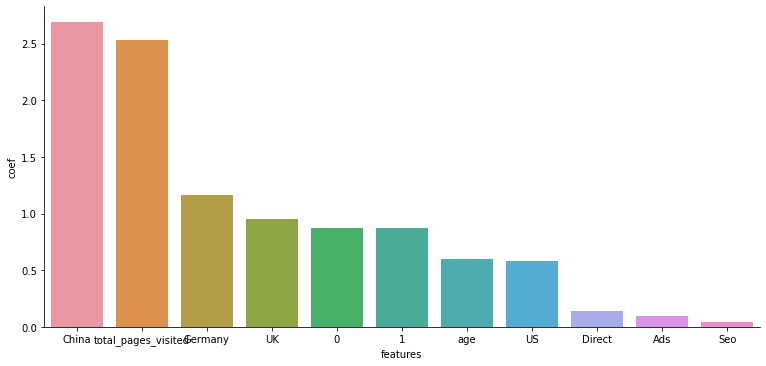

In [273]:
features_importance['coef']=features_importance['coef'].abs()
sns.catplot(x="features", 
            y="coef", 
            data=features_importance.sort_values("coef", ascending=False), 
            kind="bar",
            aspect=19/9)


# Decision Tree classifier

In [274]:
Y=data['converted']
X=data.drop(['converted'], axis=1)

In [275]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [276]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

In [277]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder()

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [278]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [279]:
Y_train_pred = classifier.predict(X_train)

In [280]:
Y_test_pred = classifier.predict(X_test)

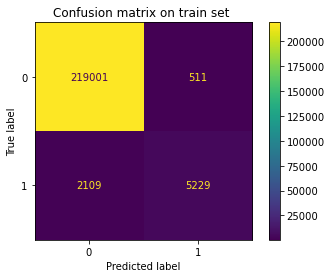

accuracy-score on train set :  0.988450517963412


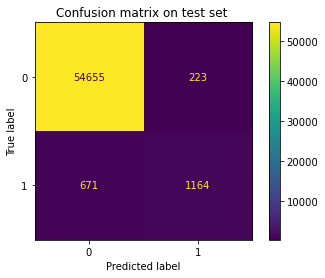

accuracy-score on test set :  0.9842364184578491


In [281]:
# Plot confusion matrix
cm = plot_confusion_matrix(classifier, X_train, Y_train)
cm.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("accuracy-score on train set : ", classifier.score(X_train, Y_train))


cm = plot_confusion_matrix(classifier, X_test, Y_test)
cm.ax_.set_title("Confusion matrix on test set ")
plt.show() # Show graph
print("accuracy-score on test set : ", classifier.score(X_test, Y_test))


In [282]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on DTC train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on DTC test set : ", f1_score(Y_test, Y_test_pred))

f1-score on DTC train set :  0.7996635571188256
f1-score on DTC test set :  0.7225325884543762


In [283]:
recall_score(Y_test, Y_test_pred)

0.6343324250681199

In [284]:
precision_score(Y_test, Y_test_pred)

0.8392213410237923

In [285]:
features_importance=pd.DataFrame({'features' : all_column_names, 'coef' : classifier.feature_importances_})
features_importance.sort_values('coef', ascending=False)

,features,coef
10,total_pages_visited,0.790979
9,age,0.072526
0,China,0.040407
4,0,0.028128
5,1,0.024106
8,Seo,0.009268
6,Ads,0.008056
3,US,0.007796
7,Direct,0.007582
2,UK,0.006256


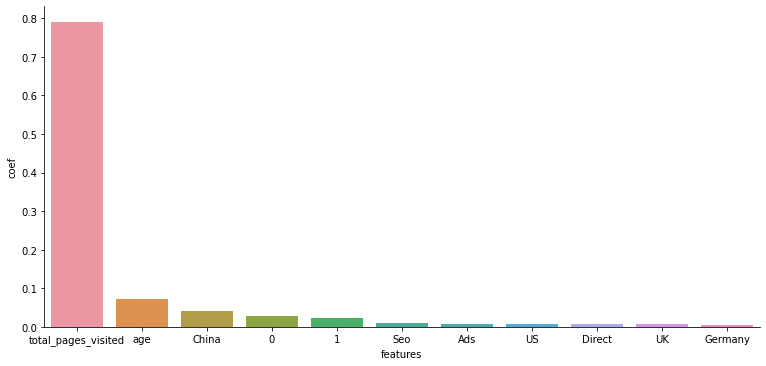

In [286]:
features_importance['coef']=features_importance['coef'].abs()
sns.catplot(x="features", 
            y="coef", 
            data=features_importance.sort_values("coef", ascending=False), 
            kind="bar",
            aspect=19/9)


# Random Forest Classifier

In [287]:
Y=data['converted']
X=data.drop(['converted'], axis=1)

In [288]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

In [289]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder()

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [290]:
classifier = RandomForestClassifier(n_estimators = 100)
classifier.fit(X_train, Y_train)

RandomForestClassifier()

In [291]:
Y_train_pred = classifier.predict(X_train)

In [292]:
Y_test_pred = classifier.predict(X_test)

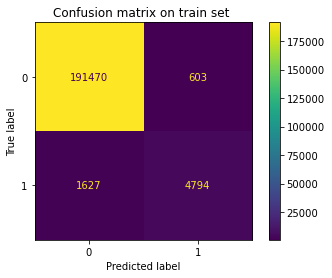

accuracy-score on train set :  0.9887654034882667


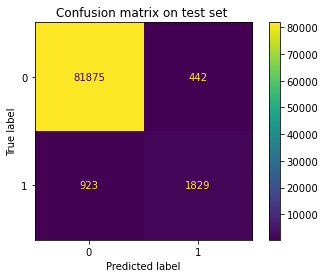

accuracy-score on test set :  0.9839542018831772


In [293]:
# Plot confusion matrix
cm = plot_confusion_matrix(classifier, X_train, Y_train)
cm.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("accuracy-score on train set : ", classifier.score(X_train, Y_train))


cm = plot_confusion_matrix(classifier, X_test, Y_test)
cm.ax_.set_title("Confusion matrix on test set ")
plt.show() # Show graph
print("accuracy-score on test set : ", classifier.score(X_test, Y_test))

In [294]:
# WARNING : Use the same score as the one that will be used by Kaggle !
# Here, the f1-score will be used to assess the performances on the leaderboard
print("f1-score on RFC train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on RFC test set : ", f1_score(Y_test, Y_test_pred))

f1-score on RFC train set :  0.8113047893044508
f1-score on RFC test set :  0.7282500497710532


In [295]:
recall_score(Y_test, Y_test_pred)

0.6646075581395349

In [296]:
precision_score(Y_test, Y_test_pred)

0.805372082782915

In [297]:
features_importance=pd.DataFrame({'features' : all_column_names, 'coef' : classifier.feature_importances_})
features_importance.sort_values('coef', ascending=False)

,features,coef
10,total_pages_visited,0.807699
9,age,0.117229
0,China,0.020810
4,0,0.018049
5,1,0.016153
2,UK,0.004713
3,US,0.004237
1,Germany,0.003228
8,Seo,0.002726
7,Direct,0.002607


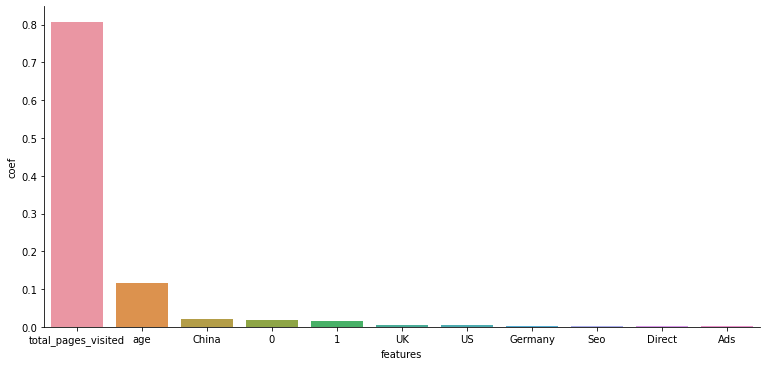

In [298]:
features_importance['coef']=features_importance['coef'].abs()
sns.catplot(x="features", 
            y="coef", 
            data=features_importance.sort_values("coef", ascending=False), 
            kind="bar",
            aspect=19/9)


# XGBoost

In [315]:
data.columns

Index(['country', 'new_user', 'source', 'age', 'total_pages_visited',
       'converted'],
      dtype='object')

In [411]:
Y=data['converted']
X=data.drop('converted', axis=1)

In [412]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'total_pages_visited']  at positions  [1, 4]
Found categorical features  ['country', 'new_user', 'source']  at positions  [0, 2, 3]


In [413]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

In [414]:
X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [415]:
model=XGBClassifier()
model.fit(X_train, Y_train)

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[12:33:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [416]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

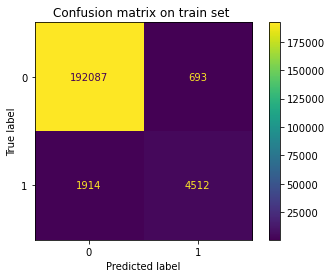

accuracy-score on train set :  0.9869130447878076


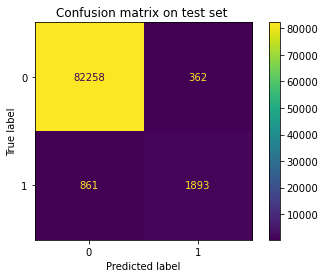

accuracy-score on test set :  0.9856747956052194


In [417]:
# Plot confusion matrix
cm = plot_confusion_matrix(model, X_train, Y_train)
cm.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("accuracy-score on train set : ", model.score(X_train, Y_train))


cm = plot_confusion_matrix(model, X_test, Y_test)
cm.ax_.set_title("Confusion matrix on test set ")
plt.show() # Show graph
print("accuracy-score on test set : ", model.score(X_test, Y_test))

In [418]:
print("f1-score on XGB train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on XGB test set : ", f1_score(Y_test, Y_test_pred))

f1-score on XGB train set :  0.775857621872582
f1-score on XGB test set :  0.755839488919944


In [ ]:
XGBClassifier()

In [432]:
param_grid={
    'max_depth': [3, 5],
    'n_estimators': [50, 60, 70],
    'learning_rate': [0.01, 0.05],
    'objective': ['reg:logistic', 'binary:hinge']
}

gridsearch=GridSearchCV(XGBClassifier(), param_grid, cv=3,n_jobs=-1, verbose=2)
gridsearch.fit(X_train, Y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 17.7min finished
/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [433]:
gridsearch.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 50,
 'objective': 'reg:logistic'}

In [434]:
gridsearch.best_score_

0.9862805337188639

In [435]:
model=gridsearch.best_estimator_

In [436]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [437]:
print("f1-score on XGB train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on XGB test set : ", f1_score(Y_test, Y_test_pred))

f1-score on XGB train set :  0.7663099758370728
f1-score on XGB test set :  0.7538677918424754


# Resampling, oversampling minority class

In [368]:
from sklearn.utils import resample

In [929]:
Y=data['converted']
X=data.drop(['converted'], axis=1)

In [930]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.32, random_state=42, stratify=Y)

In [931]:
X = pd.concat([X_train, Y_train], axis=1)
not_converted = X[X.converted==0]
converted = X[X.converted==1]

In [932]:
converted_upsampled = resample(converted,
                          replace=True, # sample with replacement
                          n_samples=int(len(not_converted)/29.5), # match number in majority class
                          random_state=27) # reproducible results

In [933]:
upsampled = pd.concat([not_converted, converted_upsampled])
upsampled.converted.value_counts()

0    187272
1      6348
Name: converted, dtype: int64

In [934]:
Y_train = upsampled.converted
X_train = upsampled.drop('converted', axis=1)

In [935]:
X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [936]:
upsampled = LogisticRegression(C=10).fit(X_train, Y_train)
Y_train_pred=upsampled.predict(X_train)
Y_test_pred = upsampled.predict(X_test)

In [954]:
grid=GridSearchCV(upsampled,param_grid={'C':[1,10]}, cv=10)
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(C=10),
             param_grid={'C': [1, 10]})

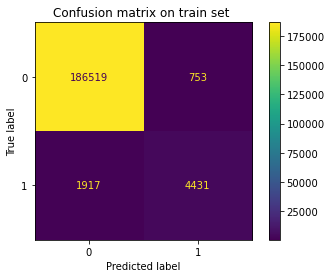

accuracy-score on train set :  0.986210102262163


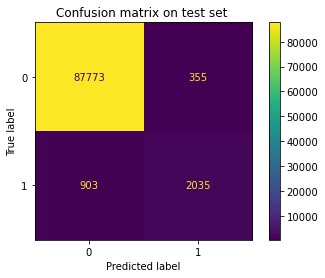

accuracy-score on test set :  0.9861858432345771


In [937]:
# Plot confusion matrix
cm = plot_confusion_matrix(upsampled, X_train, Y_train)
cm.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("accuracy-score on train set : ", upsampled.score(X_train, Y_train))


cm = plot_confusion_matrix(upsampled, X_test, Y_test)
cm.ax_.set_title("Confusion matrix on test set ")
plt.show() # Show graph
print("accuracy-score on test set : ", upsampled.score(X_test, Y_test))

In [958]:
a=grid.best_estimator_
Y_train_pred=a.predict(X_train)
Y_test_pred = a.predict(X_test)

In [959]:
print("f1-score on oversample train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on oversample test set : ", f1_score(Y_test, Y_test_pred))

f1-score on oversample train set :  0.7676276484890586
f1-score on oversample test set :  0.7624600338536768


In [888]:
recall_score(Y_test, Y_test_pred)

0.690794096978215

In [867]:
precision_score(Y_test, Y_test_pred)

0.8423013245033113

# Resampling, undersampling majority class

In [86]:
Y=data['converted']
X=data.drop(['converted'], axis=1)

In [87]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [88]:
X = pd.concat([X_train, Y_train], axis=1)
not_converted = X[X.converted==0]
converted = X[X.converted==1]

In [89]:
not_converted_downsampled = resample(not_converted,
                          replace=False, # sample with replacement
                          n_samples=len(converted), # match number in majority class
                          random_state=27) # reproducible results

In [90]:
downsampled = pd.concat([not_converted_downsampled, converted])
downsampled.converted.value_counts()

1    7344
0    7344
Name: converted, dtype: int64

In [91]:
Y_train = downsampled.converted
X_train = downsampled.drop('converted', axis=1)

In [92]:
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder()

featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = featureencoder.fit_transform(X_train)
X_test = featureencoder.transform(X_test)

In [ ]:
undersampled = LogisticRegression().fit(X_train, Y_train)
Y_train_pred=undersampled.predict(X_train)
Y_rest_pred = undersampled.predict(X_test)

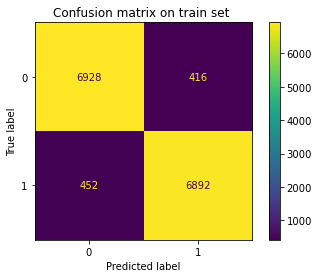

accuracy-score on train set :  0.9409041394335512


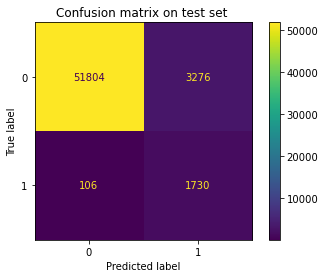

accuracy-score on test set :  0.9405790990231218


In [94]:
# Plot confusion matrix
cm = plot_confusion_matrix(undersampled, X_train, Y_train)
cm.ax_.set_title("Confusion matrix on train set ") # Simply to set a title
plt.show() # Show graph
print("accuracy-score on train set : ", undersampled.score(X_train, Y_train))


cm = plot_confusion_matrix(undersampled, X_test, Y_test)
cm.ax_.set_title("Confusion matrix on test set ")
plt.show() # Show graph
print("accuracy-score on test set : ", undersampled.score(X_test, Y_test))

In [95]:
print("f1-score on undersample train set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on undersample test set : ", f1_score(Y_test, Y_test_pred))

f1-score on undersample train set :  0.9407589407589407
f1-score on undersample test set :  0.5073572689817539


In [96]:
print(recall_score(Y_test, Y_test_pred))
print(precision_score(Y_test, Y_test_pred))

0.9389978213507625
0.34758064516129034


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [939]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

upsampled.fit(X,Y)

LogisticRegression(C=10)

In [940]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [941]:
data_without_labels

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3
...,...,...,...,...,...
31615,Germany,25,1,Seo,3
31616,US,36,1,Ads,7
31617,UK,33,1,Seo,5
31618,UK,25,1,Seo,14


In [942]:
# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = data_without_labels.columns
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [943]:
data_without_labels.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

In [944]:
data_without_labels.new_user=data_without_labels.new_user.astype(str)

In [945]:
data_without_labels.dtypes

country                object
age                     int64
new_user               object
source                 object
total_pages_visited     int64
dtype: object

In [946]:
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in data_without_labels.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['age', 'total_pages_visited']  at positions  [1, 4]
Found categorical features  ['country', 'new_user', 'source']  at positions  [0, 2, 3]


In [947]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.          1.          0.          0.          0.          1.
  -0.31092758  3.31667851]
 [ 0.          1.          0.          1.          1.          0.
  -1.0357774   0.03572688]
 [ 0.          0.          0.          1.          0.          1.
   0.17230564 -1.15734644]
 [ 0.          0.          1.          1.          0.          0.
   0.17230564  0.33399521]
 [ 0.          0.          0.          0.          0.          1.
  -0.67335249 -0.56080978]]


In [949]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': upsampled.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_upsampledGary.csv', index=False)


In [427]:
Y_predictions

,converted
0,1
1,0
2,0
3,0
4,0
...,...
31615,0
31616,0
31617,0
31618,1


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**